In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

import numpy as np
from utils import trim_state_dict_name, Flatten
from torch.autograd import Variable

from resnet3D import resnet50

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.benchmark = True

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

In [3]:
def __itensity_normalize_one_volume__(volume):
    pixels = volume[volume > 0]
    mean = pixels.mean()
    std  = pixels.std()
    out = (volume - mean)/std
    return out

# The checkpint resnet_50.pth comes from https://github.com/Tencent/MedicalNet
def get_feature_extractor():
    model = resnet50(shortcut_type='B')
    model.conv_seg = nn.Sequential(nn.AdaptiveAvgPool3d((1, 1, 1)),
                                   Flatten()) # (N, 512)
    ckpt = torch.load("../gnn/ckpt/pretrain/resnet_50.pth")
    ckpt = trim_state_dict_name(ckpt["state_dict"])
    model.load_state_dict(ckpt)
    model = nn.DataParallel(model).cuda()
    model.eval()
    print("Feature extractor weights loaded")
    return model

model = get_feature_extractor()

Feature extractor weights loaded


In [3]:
save_step = 80000 #
batch_size = 2
img_size = 256
num_samples=512
dims=2048

## HA-GAN

In [3]:
from Model_Alpha_GAN_256_SN_GN_v4_4_eval import Generator, Encoder, Sub_Encoder

latent_dim = 1024
basename = "256_1024_HA_GAN"

In [6]:
G = Generator(noise=latent_dim, mode="eval")

ckpt_path = "./checkpoint/"+basename+"/G_iter"+str(save_step)+".pth"
ckpt = torch.load(ckpt_path)
ckpt = trim_state_dict_name(ckpt)
G.load_state_dict(ckpt)

print(save_step, "step weights loaded.")
del ckpt

G = nn.DataParallel(G).cuda()
G.eval()

torch.cuda.empty_cache()

80000 step weights loaded.


In [7]:
pred_arr = np.empty((num_samples, dims))

for i in range(num_samples//batch_size):
    if i % 10 == 0:
        print('\rPropagating batch %d' % i, end='', flush=True)
    with torch.no_grad():
        noise = torch.randn((batch_size, latent_dim)).cuda()
        x_rand = G(noise, 0) # dumb index 0, not used
        x_rand = x_rand.detach()
        pred = model(x_rand)

    if (i+1)*batch_size > pred_arr.shape[0]:
        pred_arr[i*batch_size:] = pred.cpu().numpy()
    else:
        pred_arr[i*batch_size:(i+1)*batch_size] = pred.cpu().numpy()

Propagating batch 250

In [8]:
np.save("./results/pred_arr_HA_GAN.npy", pred_arr)

## HA-GAN w/o Encoder

In [2]:
from Model_GAN_256_SN_v6 import Generator

latent_dim = 1000
basename = "256_1000_HA_GAN_wo_Encoder"

In [5]:
G = Generator(noise=latent_dim, mode="eval")

ckpt_path = "./checkpoint/"+basename+"/G_iter"+str(save_step)+".pth"
ckpt = torch.load(ckpt_path)
ckpt = trim_state_dict_name(ckpt)
G.load_state_dict(ckpt)

print(save_step, "step weights loaded.")
del ckpt

G = nn.DataParallel(G).cuda()
G.eval()

torch.cuda.empty_cache()

80000 step weights loaded.


In [8]:
pred_arr = np.empty((num_samples, dims))

for i in range(num_samples//batch_size):
    if i % 10 == 0:
        print('\rPropagating batch %d' % i, end='', flush=True)
    with torch.no_grad():
        noise = torch.randn((batch_size, latent_dim)).cuda()
        x_rand = G(noise, 0) # dumb index 0, not used
        x_rand = x_rand.detach()
        pred = model(x_rand)

    if (i+1)*batch_size > pred_arr.shape[0]:
        pred_arr[i*batch_size:] = pred.cpu().numpy()
    else:
        pred_arr[i*batch_size:(i+1)*batch_size] = pred.cpu().numpy()

Propagating batch 250

In [9]:
np.save("./results/pred_arr_HA_GAN_wo_Encoder.npy", pred_arr)

## Real

In [11]:
from COPD_dataset_slim import COPD_dataset

trainset = COPD_dataset(img_size=img_size, stage="eval", threshold=600)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,drop_last=False,
                                              shuffle=False,num_workers=4)
dataloader_iterator = iter(train_loader)

Dataset size: 1000


In [12]:
pred_arr = np.empty((num_samples, dims))

for i in range(num_samples//batch_size):
    if i % 10 == 0:
        print('\rPropagating batch %d' % i, end='', flush=True)
    batch = next(dataloader_iterator).float().cuda()
    #batch = (batch+1.) / 2. # Rescale to [0, 1]
    #for j in range(batch_size):
    #    batch[j,0,:,:,:] = __itensity_normalize_one_volume__(batch[j,0,:,:,:])
    with torch.no_grad():
        pred = model(batch)

    if i*batch_size > pred_arr.shape[0]:
        pred_arr[i*batch_size:] = pred.cpu().numpy()
    else:
        pred_arr[i*batch_size:(i+1)*batch_size] = pred.cpu().numpy()

Propagating batch 250

In [13]:
np.save("./results/pred_arr_Real_v2.npy", pred_arr)

## Real_train

In [22]:
from COPD_dataset_slim import COPD_dataset

trainset = COPD_dataset(img_size=img_size, stage="train", threshold=600)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,drop_last=False,
                                              shuffle=True,num_workers=4)
dataloader_iterator = iter(train_loader)

Dataset size: 8276


In [23]:
pred_arr = np.empty((num_samples, dims))

for i in range(num_samples//batch_size):
    if i % 10 == 0:
        print('\rPropagating batch %d' % i, end='', flush=True)
    batch = next(dataloader_iterator).float().cuda()
    with torch.no_grad():
        pred = model(batch)

    if i*batch_size > pred_arr.shape[0]:
        pred_arr[i*batch_size:] = pred.cpu().numpy()
    else:
        pred_arr[i*batch_size:(i+1)*batch_size] = pred.cpu().numpy()

Propagating batch 250

In [24]:
np.save("./results/pred_arr_Real_train.npy", pred_arr)

## Alpha GAN

In [5]:
from Model_alphaWGAN_128 import Generator, Discriminator

latent_dim = 1000
basename = "128_1000_Alpha_WGAN"

In [6]:
G = Generator(noise=latent_dim)
ckpt_path = "./checkpoint/"+basename+"/G_iter"+str(save_step)+".pth"
ckpt = torch.load(ckpt_path)
ckpt = trim_state_dict_name(ckpt)
G.load_state_dict(ckpt)

E = Discriminator(out_class = latent_dim, is_dis=False)
ckpt_path = "./checkpoint/"+basename+"/E_iter"+str(save_step)+".pth"
ckpt = torch.load(ckpt_path)
ckpt = trim_state_dict_name(ckpt)
E.load_state_dict(ckpt)

print("Weights step", save_step, "loaded.")
del ckpt

G = nn.DataParallel(G).cuda()
E = nn.DataParallel(E).cuda()

G.eval()
E.eval()

Weights step 80000 loaded.


In [7]:
pred_arr = np.empty((num_samples, dims))

for i in range(num_samples//batch_size):
    if i % 10 == 0:
        print('\rPropagating batch %d' % i, end='', flush=True)
    with torch.no_grad():
        noise = torch.randn((batch_size, latent_dim)).cuda()
        x_rand = G(noise)
        x_rand = x_rand.detach()
        x_rand = F.interpolate(x_rand, scale_factor = 2)
        pred = model(x_rand)
    if (i+1)*batch_size > pred_arr.shape[0]:
        pred_arr[i*batch_size:] = pred.cpu().numpy()
    else:
        pred_arr[i*batch_size:(i+1)*batch_size] = pred.cpu().numpy()

Propagating batch 250

In [8]:
np.save("./results/pred_arr_baseline_Alpha_GAN.npy", pred_arr)

## VAE-GAN

In [5]:
from Model_VAEGAN import Encoder, Generator

latent_dim = 1000
basename = "128_1000_VAE_GAN"

In [6]:
G = Generator(noise=latent_dim)
ckpt_path = "./checkpoint/"+basename+"/G_iter"+str(save_step)+".pth"
ckpt = torch.load(ckpt_path)
ckpt = trim_state_dict_name(ckpt)
G.load_state_dict(ckpt)

E = Encoder(latent_size=latent_dim)
ckpt_path = "./checkpoint/"+basename+"/E_iter"+str(save_step)+".pth"
ckpt = torch.load(ckpt_path)
ckpt = trim_state_dict_name(ckpt)
E.load_state_dict(ckpt)

# load params
print("Weights step", save_step, "loaded.")
del ckpt
G = nn.DataParallel(G).cuda()
E = nn.DataParallel(E).cuda()
G.eval()
E.eval()

Weights step 80000 loaded.


DataParallel(
  (module): Encoder(
    (conv1): Conv3d(1, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (conv2): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (bn3): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (bn4): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv3d(256, 512, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (bn5): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv6): Conv3d(512, 512, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (bn6): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True

In [7]:
pred_arr = np.empty((num_samples, dims))

for i in range(num_samples//batch_size):
    if i % 10 == 0:
        print('\rPropagating batch %d' % i, end='', flush=True)
    with torch.no_grad():
        code = torch.randn((batch_size, latent_dim)).cuda()
        x_hat = G(code)
        x_hat = x_hat.detach()
        x_hat = F.interpolate(x_hat, scale_factor = 2)
        x_hat = (x_hat+1.) / 2. # Rescale to [0, 1]
        for j in range(batch_size):
            x_hat[j,0,:,:,:] = __itensity_normalize_one_volume__(x_hat[j,0,:,:,:])
        pred = model(x_hat)

    if (i+1)*batch_size > pred_arr.shape[0]:
        pred_arr[i*batch_size:] = pred.cpu().numpy()
    else:
        pred_arr[i*batch_size:(i+1)*batch_size] = pred.cpu().numpy()

Propagating batch 250

In [8]:
np.save("./results/pred_arr_baseline_VAEGAN.npy", pred_arr)

## WGAN

In [5]:
from Model_WGAN_128 import Generator

latent_dim = 1024
basename = "128_1024_WGAN"

In [6]:
G = Generator(noise=latent_dim)
ckpt_path = "./checkpoint/"+basename+"/G_iter"+str(save_step)+".pth"
ckpt = torch.load(ckpt_path)
ckpt = trim_state_dict_name(ckpt)
G.load_state_dict(ckpt)

print("Weights step", save_step, "loaded.")
del ckpt

G = nn.DataParallel(G).cuda()

G.eval()

Weights step 80000 loaded.


DataParallel(
  (module): Generator(
    (relu): ReLU()
    (tp_conv1): ConvTranspose3d(1024, 1024, kernel_size=(4, 4, 4), stride=(1, 1, 1), bias=False)
    (bn1): BatchNorm3d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (tp_conv2): Conv3d(1024, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (bn2): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (tp_conv3): Conv3d(512, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (tp_conv4): Conv3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (bn4): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (tp_conv5): Conv3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (bn5): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine

In [7]:
pred_arr = np.empty((num_samples, dims))

for i in range(num_samples//batch_size):
    if i % 10 == 0:
        print('\rPropagating batch %d' % i, end='', flush=True)
    with torch.no_grad():
        noise = torch.randn((batch_size, latent_dim)).cuda()
        x_rand = G(noise)
        x_rand = x_rand.detach()
        x_rand = F.interpolate(x_rand, scale_factor = 2)
        pred = model(x_rand)
    if (i+1)*batch_size > pred_arr.shape[0]:
        pred_arr[i*batch_size:] = pred.cpu().numpy()
    else:
        pred_arr[i*batch_size:(i+1)*batch_size] = pred.cpu().numpy()

Propagating batch 250

In [8]:
np.save("./results/pred_arr_baseline_WGAN.npy", pred_arr)

## Progressive GAN

In [9]:
import SimpleITK as sitk

RESULT_DIR = "./progressivegan3d/results/copd_128/"

def load_img(path):
    img = sitk.ReadImage(path)
    img = sitk.GetArrayFromImage(img)
    img = img/255.*2.-1
    return img

In [10]:
pred_arr = np.empty((num_samples, dims))

for i in range(num_samples//batch_size):
    if i % 10 == 0:
        print('\rPropagating batch %d' % i, end='', flush=True)
    batch = []
    for j in range(batch_size):
        batch.append(load_img(RESULT_DIR+str(i*batch_size+j)+".nii.gz"))
    batch = np.stack(batch)
    batch = torch.from_numpy(batch[:,None,:,:,:]).float().cuda()
    batch = F.interpolate(batch, scale_factor = 2)
    #batch = (batch+1.) / 2. # Rescale to [0, 1]
    #for j in range(batch_size):
    #    batch[j,0,:,:,:] = __itensity_normalize_one_volume__(batch[j,0,:,:,:])
    with torch.no_grad():
        pred = model(batch)

    if i*batch_size > pred_arr.shape[0]:
        pred_arr[i*batch_size:] = pred.cpu().numpy()
    else:
        pred_arr[i*batch_size:(i+1)*batch_size] = pred.cpu().numpy()

Propagating batch 250

In [11]:
np.save("./results/pred_arr_baseline_PGAN.npy", pred_arr)

## PCA

In [4]:
pred_arr_list=[]

for model_name in ["Real", "HA_GAN", "baseline_Alpha_GAN", "baseline_VAEGAN", "baseline_PGAN", "baseline_WGAN"]:
    pred_arr_list.append(np.load("./results/pred_arr_"+model_name+".npy"))

pred_arr_list = np.concatenate(pred_arr_list)

In [6]:
pred_arr_list.shape

(3072, 2048)

In [5]:
num_components=10

pca = PCA(n_components = num_components)
pred_arr_list_pca=pca.fit_transform(pred_arr_list)

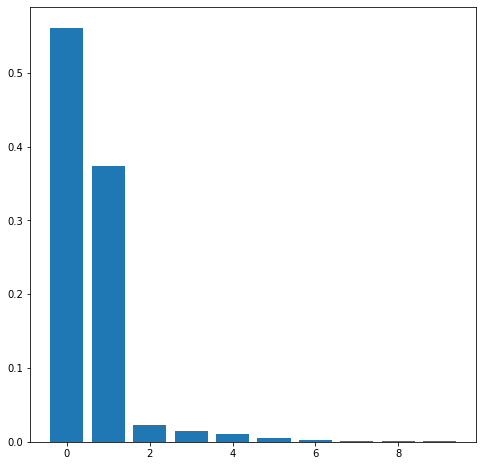

In [8]:
plt.figure(figsize=(8,8))
plt.bar(range(num_components), pca.explained_variance_ratio_)
plt.show()

In [6]:
def fit_eclipse(x,y):
    N = 300
    xmean, ymean = x.mean(), y.mean()
    x -= xmean
    y -= ymean
    U, S, V = np.linalg.svd(np.stack((x, y)))

    tt = np.linspace(0, 2*np.pi, 1000)
    circle = np.stack((np.cos(tt), np.sin(tt)))    # unit circle
    transform = np.sqrt(2/N) * U.dot(np.diag(S))   # transformation matrix
    fit = transform.dot(circle) + np.array([[xmean], [ymean]])
    return fit
    plt.plot(fit[0, :], fit[1, :], 'r')

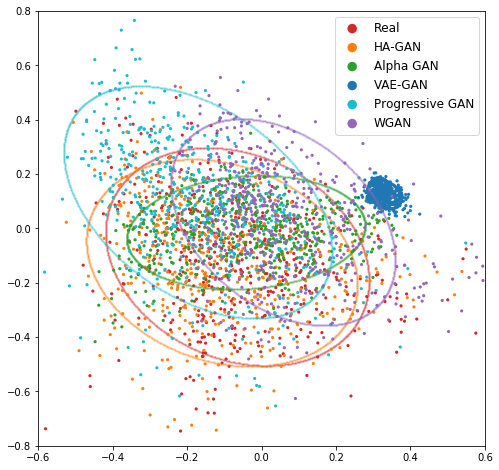

In [8]:
colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue', 'tab:cyan', 'tab:purple']
models = ["Real", "HA-GAN", "Alpha GAN", "VAE-GAN", "Progressive GAN", "WGAN"]

fig, ax = plt.subplots(figsize=(8, 8))

for i in range(6):
    ax.scatter(pred_arr_list_pca[512*i:512*(i+1),0], pred_arr_list_pca[512*i:512*(i+1),1],
               c=colors[i], s=10, label=models[i],
               alpha=1, edgecolors='none')
    fit = fit_eclipse(pred_arr_list_pca[512*i:512*(i+1),0].copy(), pred_arr_list_pca[512*i:512*(i+1),1].copy())
    ax.scatter(fit[0, :], fit[1, :], c=colors[i], s=2, alpha=0.2)

ax.legend()
#ax.grid(True)

plt.xlim(-0.6, 0.6)
plt.ylim(-0.8, 0.8)

plt.legend(prop={'size': 12}, markerscale=3.)
plt.savefig("./results/PCA_COPD.pdf", bbox_inches='tight')
#plt.show()

## MMD

In [12]:
from torch_two_sample.statistics_diff import MMDStatistic
import torch

In [13]:
mmd = MMDStatistic(num_samples, num_samples)

In [26]:
for i, model_name in enumerate(["Real_train", "HA_GAN", "HA_GAN_wo_Encoder", "baseline_Alpha_GAN", "baseline_VAEGAN", "baseline_PGAN", "baseline_WGAN"]):
    print(model_name)
    sample_1 = torch.from_numpy(np.load("./results/pred_arr_Real.npy"))
    sample_2 = torch.from_numpy(np.load("./results/pred_arr_"+model_name+".npy"))

    test_statistics, ret_matrix = mmd(sample_1, sample_2, alphas='median', ret_matrix=True)
    #p = mmd.pval(ret_matrix.float(), n_permutations=1000)

    print("Test statistics:", test_statistics.item())
    #print("P-value:", p)

Real_train
Test statistics: 0.00025213379519284373
HA_GAN
Test statistics: 0.012256970962861824
HA_GAN_wo_Encoder
Test statistics: 0.026077890148852034
baseline_Alpha_GAN_no_eval
Test statistics: 0.09993166270010817
baseline_VAEGAN
Test statistics: 1.0247064775299697
baseline_PGAN
Test statistics: 0.14293482895837467
baseline_WGAN
Test statistics: 0.13438738230748448
